In [50]:
import tensorflow as tf
import cv2
import random
import numpy as np
import PIL.Image as Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import Image, display
import os
# from focal_loss import SparseCategoricalFocalLoss

In [2]:
from tensorflow import keras
import keras.layers as kl
import tensorflow.keras.backend as K

In [3]:
import os
import shutil 
isExist = os.path.exists("/kaggle/working/temp")
if not isExist:
    os.makedirs("/kaggle/working/temp")
else:
    shutil.rmtree("/kaggle/working/temp")
    os.makedirs("/kaggle/working/temp")

In [4]:
EPOCHS=200
IMG_SIZE=256
BATCH_SIZE=32
LEARNING_RATE=0.00005
dropout_rate=0.3
EarlyStoppingPatience=20

In [5]:
import os

output_path = "/kaggle/working/temp/"
train_dir = "/kaggle/input/darklight-augmented2/organized_augmented/train"
test_dir = "/kaggle/input/darklight-augmented2/organized_augmented/test"
val_dir = "/kaggle/input/darklight-augmented2/organized_augmented/val"

classes = sorted(os.listdir(train_dir))
print(classes)

['AK', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'SCC', 'VASC']


In [6]:
# import os
# # data_root="/kaggle/input/skin-lesion-dataset-organized/Organized"
# output_path="/kaggle/working/temp/"
# # train_dir=data_root+"/train/"
# # val_dir=data_root+"/val/"
# # test_dir=data_root+"/test/"
# train_dir="/kaggle/input/skin-lesion-dataset-organized/Organized/train"
# test_dir="/kaggle/input/skin-lesion-dataset-organized/Organized/test"
# val_dir="/kaggle/input/skin-lesion-dataset-organized/Organized/val"
# classes=sorted(os.listdir(train_dir))
# print(classes)

In [7]:
from glob import glob
num_classes = len(os.listdir(train_dir))
num_train_images = len(glob(train_dir + '/*/*'))
num_val_images = len(glob(val_dir + '/*/*'))
num_test_images = len(glob(test_dir + '/*/*'))

print("num_classes : ", num_classes)
print("num_train_images : ", num_train_images)
print("num_val_images : ", num_val_images)
print("num_test_images : ", num_test_images)

num_classes :  8
num_train_images :  24414
num_val_images :  3851
num_test_images :  3896


In [8]:
import math
BUFFER_SIZE=num_train_images
AUTO=tf.data.experimental.AUTOTUNE
TRAIN_STEPS_PER_EPOCH=math.ceil(num_train_images/BATCH_SIZE)
VAL_STEPS_PER_EPOCH=math.ceil(num_val_images/BATCH_SIZE)
TEST_STEPS_PER_EPOCH=math.ceil(num_test_images/BATCH_SIZE)

In [9]:
import tensorflow as tf
import random
from glob import glob

def parse_image(filename, label):
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    
    image = tf.cast(image, tf.float32) / 255.0
    
    image = tf.image.random_brightness(image, max_delta=0.2)  
    
    return image, label

file_names_train = glob(train_dir + '/*/*')
random.shuffle(file_names_train)    
lbls_train = [classes.index(name.split('/')[-2]) for name in file_names_train]
train_dataset = tf.data.Dataset.from_tensor_slices((file_names_train, lbls_train))

train_dataset = (
    train_dataset
    .shuffle(buffer_size=BUFFER_SIZE)
    .map(parse_image, num_parallel_calls=AUTO) 
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=AUTO)
)

file_names_val = glob(val_dir + '/*/*')     
lbls_val = [classes.index(name.split('/')[-2]) for name in file_names_val]
validation_dataset = tf.data.Dataset.from_tensor_slices((file_names_val, lbls_val))

validation_dataset = (
    validation_dataset
    .map(parse_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=AUTO)
)

file_names_test = glob(test_dir + '/*/*')    
lbls_test = [classes.index(name.split('/')[-2]) for name in file_names_test]
test_dataset = tf.data.Dataset.from_tensor_slices((file_names_test, lbls_test))

test_dataset = (
    test_dataset    
    .map(parse_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=AUTO)
)

In [10]:
tr_lb=np.array(lbls_train)
tr_lb_unique=np.unique(tr_lb)
print((np.unique(tr_lb, return_counts=True)))

from sklearn.utils import compute_class_weight
#formula: n_samples / (n_classes * np.bincount(y))
classWeight=compute_class_weight(class_weight="balanced",classes=tr_lb_unique,y=tr_lb)
classWeight = dict(zip(tr_lb_unique, classWeight))
print("classWeight : ",classWeight)

(array([0, 1, 2, 3, 4, 5, 6, 7]), array([2000, 2345, 1802, 2000, 3158, 9109, 2000, 2000]))
classWeight :  {0: 1.525875, 1: 1.3013859275053306, 2: 1.693534961154273, 3: 1.525875, 4: 0.9663552881570614, 5: 0.3350257986606653, 6: 1.525875, 7: 1.525875}


In [11]:
# !pip install git+https://www.github.com/keras-team/keras-contrib.git

In [12]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow.keras.layers as KL
import tensorflow.keras.models as KM

def channel_attention(features: int, reduction: int = 16, name: str = "") -> KM.Model:
    """channel attention model
    Args:
        features (int): number of features for incoming tensor
        reduction (int, optional): Reduction ratio for the MLP to squeeze information across channels. Defaults to 16.
        name (str, optional): Defaults to "".
    Returns:
        KM.Model: channelwise attention appllier model
    """

    input_tensor = KL.Input(shape=(None, None, features))

    # Average pool over a feature map across channels
    avg = tf.reduce_mean(input_tensor, axis=[1, 2], keepdims=True)
    # Max pool over a feature map across channels
    max_pool = tf.reduce_max(input_tensor, axis=[1, 2], keepdims=True)

    # Number of features for middle layer of shared MLP
    reduced_features = int(features // reduction)

    dense1 = KL.Dense(reduced_features)
    avg_reduced = dense1(avg)
    max_reduced = dense1(max_pool)

    dense2 = KL.Dense(features)
    avg_attention = dense2(KL.Activation("relu")(avg_reduced))
    max_attention = dense2(KL.Activation("relu")(max_reduced))

    # Channel-wise attention
    overall_attention = KL.Activation("sigmoid")(avg_attention + max_attention)

    return KM.Model(
        inputs=input_tensor, outputs=input_tensor * overall_attention, name=name
    )


def spatial_attention(
    features: int, kernel: int = 7, bias: bool = False, name: str = ""
) -> KM.Model:
    """spatial attention model
    Args:
        features (int): number of features for incoming tensor
        kernel (int): convolutional kernel size
        bias (bool, optional): whether to use bias in convolutional layer
        name (str, optional): Defaults to "".
    Returns:
        KM.Model: spatial attention appllier model
    """

    input_tensor = KL.Input(shape=(None, None, features))
    # Average pool across channels for a given spatial location
    avg = tf.reduce_mean(input_tensor, axis=[-1], keepdims=True)

    # Max pool across channels for a given spatial location
    max_pool = tf.reduce_max(input_tensor, axis=[-1], keepdims=True)

    concat_pool = tf.concat([avg, max_pool], axis=-1)

    # Attention for spatial locations
    conv = KL.Conv2D(
        1, (kernel, kernel), strides=(1, 1), padding="same", use_bias=bias
    )(concat_pool)
    attention = KL.Activation("sigmoid")(KL.BatchNormalization()(conv))

    return KM.Model(inputs=input_tensor, outputs=input_tensor * attention, name=name)


def cbam_block(
    input_tensor: tf.Tensor,
    features: int,
    kernel: int = 7,
    spatial: bool = False,
    name: str = "",
) -> tf.Tensor:
    """Convolutional Block Attention Module as proposed by Woo et. al in
    CBAM: Convolutional Block Attention Module
    Args:
        input_tensor (tf.Tensor): feature tensor
        features (int): number of features for incoming layer
        kernel (int): kernel size for spatial attention module
        spatial (bool, optional): whether to apply spatial attention. Defaults to False.
                                False: equivalent to squueze and excitation block with both max and avg. pool.
        name (str, optional): Defaults to "".
    Returns:
        tf.Tensor: Attention-scaled feature tensor
    """

    out_tensor = channel_attention(features, name=name + "chn")(input_tensor)
    if spatial:
        out_tensor = spatial_attention(features, kernel=kernel, name=name + "spt")(
            out_tensor
        )
    return out_tensor


inputs = keras.Input(shape=(256, 256, 3))

# Depthwise separable convolutional layers
x = layers.DepthwiseConv2D(3, activation='relu', padding='same')(inputs)
x = layers.BatchNormalization()(x)

x = cbam_block(x, features=x.shape[-1], spatial=True)
x = layers.MaxPooling2D(pool_size=(2, 2), strides=2)(x)

x = layers.DepthwiseConv2D(3, activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=(2, 2), strides=2)(x)

x = layers.Flatten()(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)

x = layers.Dense(128, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)

x = layers.Dense(64, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(8, activation='softmax')(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 depthwise_conv2d (Depthwise  (None, 256, 256, 3)      30        
 Conv2D)                                                         
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 3)      12        
 ormalization)                                                   
                                                                 
 chn (Functional)            (None, None, None, 3)     3         
                                                                 
 spt (Functional)            (None, None, None, 3)     102       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 3)      0     

In [13]:
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers
# from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,Input

# inputs = keras.Input(shape=(256,256,3))
# x = layers.Conv2D(32,(3,3))(inputs)
# x = layers.BatchNormalization()(x)
# x = keras.activations.relu(x)
# x = layers.MaxPooling2D(pool_size=(2,2),strides=2)(x)
# x = layers.Conv2D(64,(3,3))(x)
# x = layers.BatchNormalization()(x)
# x = keras.activations.relu(x)
# x = layers.MaxPooling2D(pool_size=(2,2),strides=2)(x)
# x = layers.Flatten()(x)
# x = layers.Dense(256,activation="relu")(x)
# x = layers.Dense(128,activation="relu")(x)
# x = layers.Dense(64,activation="relu")(x)
# outputs = layers.Dense(8,activation='softmax')(x)
# model = keras.Model(inputs=inputs, outputs=outputs)

# # inputs =keras.Input(shape=(256,256,1))
# # x = Conv2D(32,(3,3),activation='relu')(inputs)  
# # x = layers.BatchNormalization()(x)
# # x = MaxPooling2D(pool_size=(2,2),strides=2)(x)  
# # x = Conv2D(64,(3,3),activation='relu')(x)       
# # x = MaxPooling2D(pool_size=(2,2),strides=2)(x)  
# # x = Flatten()(x)                                
# # x = Dense(128,activation='relu')(x)              
# # x = Dense(64,activation='relu')(x)              
# # outputs = Dense(8,activation='softmax')(x)      
# # model = tf.keras.Model(inputs=inputs,outputs=outputs)

# model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
# model.summary()

In [14]:
EarlyStop=keras.callbacks.EarlyStopping(
    monitor="val_accuracy",patience=EarlyStoppingPatience,
    restore_best_weights=True, min_delta=0.001, verbose=1)

ModelCheckPoint=keras.callbacks.ModelCheckpoint(
    filepath=output_path+'model_standard-{epoch:03d}-{val_accuracy:.4f}.hdf5',
    monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)

In [15]:
initial_learning_rate = LEARNING_RATE
decay = initial_learning_rate / EPOCHS

def lr_time_based_decay(epoch, lr):
    return lr * 1 / (1 + decay * epoch)

def lr_step_decay(epoch, lr):
    drop_rate = 0.5
    epochs_drop = 40.0
    return initial_learning_rate * math.pow(drop_rate, math.floor(epoch/epochs_drop))

LRSchedule = tf.keras.callbacks.LearningRateScheduler(lr_step_decay)

In [16]:
def convert(seconds):
    hour = seconds // 3600
    seconds %= 3600
    minutes = seconds // 60
    seconds %= 60     
    return "%d:%02d:%02d" % (hour, minutes, seconds)

In [17]:
import time
t1=time.time()
history = model.fit(
    train_dataset,
    steps_per_epoch=TRAIN_STEPS_PER_EPOCH,
    epochs=EPOCHS,
    class_weight=classWeight,
    validation_data=validation_dataset,
    validation_steps=VAL_STEPS_PER_EPOCH,
    callbacks=[ModelCheckPoint, EarlyStop, LRSchedule]  
)
t2=time.time()
time_taken = t2-t1
print("Time taken : ",convert(time_taken)," hh:mm:ss")

Epoch 1/200
763/763 [==============================] - ETA: 0s - loss: 2.5692 - accuracy: 0.1939
Epoch 1: val_accuracy improved from -inf to 0.15866, saving model to /kaggle/working/temp/model_standard-001-0.1587.hdf5
763/763 [==============================] - 404s 515ms/step - loss: 2.5692 - accuracy: 0.1939 - val_loss: 2.1592 - val_accuracy: 0.1587 - lr: 5.0000e-05
Epoch 2/200
763/763 [==============================] - ETA: 0s - loss: 2.2738 - accuracy: 0.2390
Epoch 2: val_accuracy improved from 0.15866 to 0.33498, saving model to /kaggle/working/temp/model_standard-002-0.3350.hdf5
763/763 [==============================] - 322s 422ms/step - loss: 2.2738 - accuracy: 0.2390 - val_loss: 1.8231 - val_accuracy: 0.3350 - lr: 5.0000e-05
Epoch 3/200
763/763 [==============================] - ETA: 0s - loss: 2.1325 - accuracy: 0.2741
Epoch 3: val_accuracy did not improve from 0.33498
763/763 [==============================] - 254s 332ms/step - loss: 2.1325 - accuracy: 0.2741 - val_loss: 1.80

In [18]:
import pandas as pd 
Hist = {'hist' : history.history}
df = pd.DataFrame.from_dict(Hist)  
df.to_csv(output_path+r'Hist.csv', index = True, header=True)

In [20]:
model.load_weights('/kaggle/working/temp/model_standard-120-0.8110.hdf5')
test_loss, test_accuracy_by_evaluate = model.evaluate(test_dataset)

122/122 [==============================] - 56s 455ms/step - loss: 1.2423 - accuracy: 0.7918


In [21]:
test_accuracy_by_evaluate_rounded = round((test_accuracy_by_evaluate)*100, 2)
num_epoch = len(history.history['loss'])
executed_epoch_count = len(history.history['loss'])
savedfilename="epochs_{}".format(executed_epoch_count)+"_test_acc_{}".format(test_accuracy_by_evaluate_rounded)

name=output_path+r"{}".format(savedfilename)+".hdf5"
model.save(name)

name_weights=output_path+r"{}".format(savedfilename)+"_weights.hdf5"
model.save_weights(name_weights)

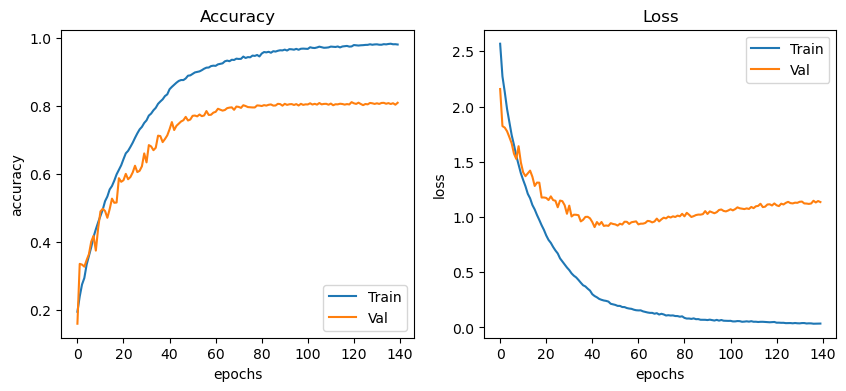

In [24]:
figpath=output_path+r"{}".format(savedfilename)+".pdf"
fig = plt.figure(figsize=(10,4))
epochs_range = range(len(history.history['loss']))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, history.history['accuracy'], label='Train')
plt.plot(epochs_range, history.history['val_accuracy'], label='Val')
plt.legend(loc='lower right')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, history.history['loss'], label='Train')
plt.plot(epochs_range, history.history['val_loss'], label='Val')
plt.legend(loc='upper right')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()
fig.savefig(figpath, format='pdf')

In [25]:
predictions=model.predict(test_dataset)
y_pred = np.argmax(predictions, axis=1)
y_true = np.concatenate([y for x, y in test_dataset], axis=0)
y_prob = predictions

122/122 [==============================] - 47s 378ms/step


In [26]:
same = 0
total = len(y_true)

for i in range(total):
    if y_true[i] == y_pred[i]:
        same=same+1
        
test_acc = same/total*100
res='{:.2f}'.format(test_acc)
print(same)
print(total)
print(res)

3098
3896
79.52


In [27]:
from tensorflow.keras.utils import to_categorical
y_test = to_categorical(y_true)
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(y_true, y_pred)
print('Confusion Matrix\n')
print(confusion)

Confusion Matrix

[[  23   43    8    1   18   37    8    0]
 [  20  419   14    3   16   40    6    2]
 [   4   21  285    1   20   49    3    1]
 [   2    3    4    2    8   18    2    0]
 [  14   26   27    1  586   85    4    2]
 [  14   39   29    2   74 1772    4    1]
 [  15   28   11    2   17   20   10    2]
 [   0    1    2    0    3   22    1    1]]


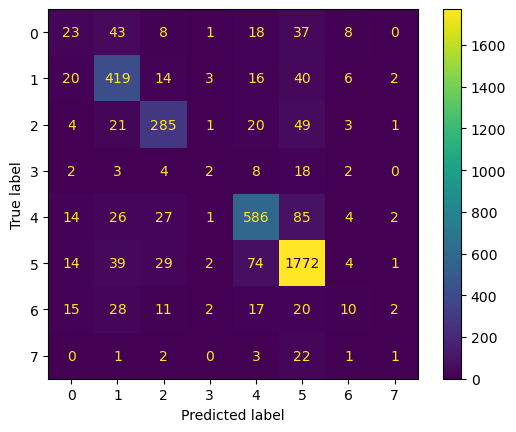

In [28]:
fig_path=output_path+r"confusion_matrix.pdf"
from sklearn.metrics import ConfusionMatrixDisplay
cm_display = ConfusionMatrixDisplay(confusion).plot()
fig = cm_display.figure_
fig.savefig(fig_path, format='pdf')

In [29]:
y_prob = np.array(y_prob)

In [30]:
from sklearn.metrics import roc_auc_score
targetnames=classes
fpr = {}
tpr = {}
roc_auc = {}
for i in range(num_classes):
    r = roc_auc_score(y_test[:, i], y_prob[:, i])
    print("The ROC AUC score of "+targetnames[i]+" is: "+str(r))

The ROC AUC score of AK is: 0.8708764298000016
The ROC AUC score of BCC is: 0.9512395187750637
The ROC AUC score of BKL is: 0.9346926608769932
The ROC AUC score of DF is: 0.7904708721405637
The ROC AUC score of MEL is: 0.926324656708534
The ROC AUC score of NV is: 0.9500585710765616
The ROC AUC score of SCC is: 0.8428207157302383
The ROC AUC score of VASC is: 0.8217192619417142


In [31]:
from sklearn.metrics import roc_curve, auc
fpr = {}
tpr = {}
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_prob[:, i], drop_intermediate=False)
    roc_auc[i] = auc(fpr[i], tpr[i])

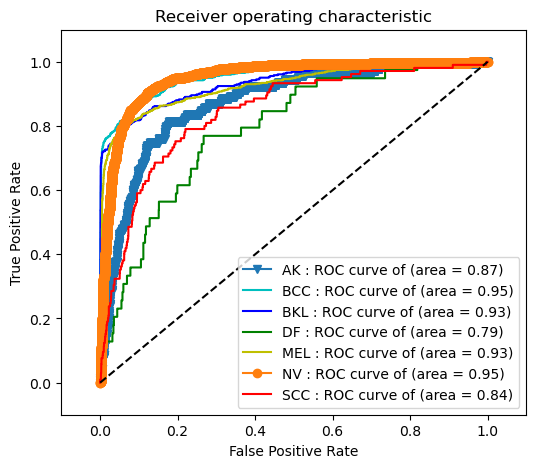

In [32]:
fig_path_roc=output_path+r"roc_auc_curve.pdf"
fig = plt.figure(figsize=(6,5))
l0="{}".format(targetnames[0])+" : ROC curve of (area = {}".format(round(roc_auc[0],2))+")"
l1="{}".format(targetnames[1])+" : ROC curve of (area = {}".format(round(roc_auc[1],2))+")"
l2="{}".format(targetnames[2])+" : ROC curve of (area = {}".format(round(roc_auc[2],2))+")"
l3="{}".format(targetnames[3])+" : ROC curve of (area = {}".format(round(roc_auc[3],2))+")"
l4="{}".format(targetnames[4])+" : ROC curve of (area = {}".format(round(roc_auc[4],2))+")"
l5="{}".format(targetnames[5])+" : ROC curve of (area = {}".format(round(roc_auc[5],2))+")"
l6="{}".format(targetnames[6])+" : ROC curve of (area = {}".format(round(roc_auc[6],2))+")"
plt.plot(fpr[0], tpr[0],'v-',label=l0)
plt.plot(fpr[1], tpr[1],'c' ,label=l1)
plt.plot(fpr[2], tpr[2],'b' ,label=l2)
plt.plot(fpr[3], tpr[3],'g' ,label=l3)
plt.plot(fpr[4], tpr[4],'y' ,label=l4)
plt.plot(fpr[5], tpr[5],'o-',label=l5)
plt.plot(fpr[6], tpr[6],'r' ,label=l6)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()
fig.savefig(fig_path_roc, format='pdf')

In [33]:
from sklearn.metrics import accuracy_score
accuracy_score = accuracy_score(y_true, y_pred)
print('Accuracy: {}'.format(accuracy_score))

Accuracy: 0.7951745379876797


In [34]:
from sklearn.metrics import classification_report
classification_report = classification_report(y_true, y_pred, 
    target_names=targetnames, zero_division=0)
print('Classification Report : \n')
print(classification_report)

Classification Report : 

              precision    recall  f1-score   support

          AK       0.25      0.17      0.20       138
         BCC       0.72      0.81      0.76       520
         BKL       0.75      0.74      0.75       384
          DF       0.17      0.05      0.08        39
         MEL       0.79      0.79      0.79       745
          NV       0.87      0.92      0.89      1935
         SCC       0.26      0.10      0.14       105
        VASC       0.11      0.03      0.05        30

    accuracy                           0.80      3896
   macro avg       0.49      0.45      0.46      3896
weighted avg       0.77      0.80      0.78      3896



In [35]:
from sklearn.metrics import precision_score, recall_score, f1_score
micro_precision = precision_score(y_true, y_pred, average='micro', zero_division=0)
macro_precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
weighted_precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)

print(f"Micro Precision: {micro_precision}")
print(f"Macro Precision: {macro_precision}")
print(f"Weighted Precision: {weighted_precision}")

micro_recall = recall_score(y_true, y_pred, average='micro', zero_division=0)
macro_recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
weighted_recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)

print(f"Micro Recall: {micro_recall}")
print(f"Macro Recall: {macro_recall}")
print(f"Weighted Recall: {weighted_recall}")

micro_f1 = f1_score(y_true, y_pred, average='micro', zero_division=0)
macro_f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
weighted_f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

print(f"Micro F1: {micro_f1}")
print(f"Macro F1: {macro_f1}")
print(f"Weighted F1: {weighted_f1}")

Micro Precision: 0.7951745379876797
Macro Precision: 0.4900573514310273
Weighted Precision: 0.7706148224130183
Micro Recall: 0.7951745379876797
Macro Recall: 0.44960204154990496
Weighted Recall: 0.7951745379876797
Micro F1: 0.7951745379876798
Macro F1: 0.45706613530394063
Weighted F1: 0.7804398998315163


In [37]:
from sklearn.metrics import roc_auc_score
micro_roc_auc_ovr = roc_auc_score(y_test,y_prob,multi_class="ovr",average="micro")
macro_roc_auc_ovr = roc_auc_score(y_test,y_prob,multi_class="ovr",average="macro")
weighted_roc_auc_ovr = roc_auc_score(y_true,y_prob,multi_class='ovr',average='weighted')

print(f"Micro-averaged One-vs-Rest ROC AUC score: {micro_roc_auc_ovr}")
print(f"Macro-averaged One-vs-Rest ROC AUC score: {macro_roc_auc_ovr}")
print(f"Weighted One-vs-Rest ROC AUC score: {weighted_roc_auc_ovr}")

Micro-averaged One-vs-Rest ROC AUC score: 0.9559075339887227
Macro-averaged One-vs-Rest ROC AUC score: 0.8860253358812088
Weighted One-vs-Rest ROC AUC score: 0.9358826489108346


In [38]:
from sklearn.metrics import balanced_accuracy_score
balanced_accuracy_score = balanced_accuracy_score(y_true, y_pred)
print('balanced_accuracy_score : ', balanced_accuracy_score)

balanced_accuracy_score :  0.44960204154990496


In [39]:
from sklearn.metrics import jaccard_score
jaccard_score = jaccard_score(y_true, y_pred, average='weighted')
print('jaccard_score : ', jaccard_score)
jaccard_score :  0.726511851328315

jaccard_score :  0.6706574791918519


In [41]:
from sklearn.metrics import multilabel_confusion_matrix
multilabel_confusion_matrix = multilabel_confusion_matrix(y_true, y_pred)
print('multilabel_confusion_matrix : \n', multilabel_confusion_matrix)

multilabel_confusion_matrix : 
 [[[3689   69]
  [ 115   23]]

 [[3215  161]
  [ 101  419]]

 [[3417   95]
  [  99  285]]

 [[3847   10]
  [  37    2]]

 [[2995  156]
  [ 159  586]]

 [[1690  271]
  [ 163 1772]]

 [[3763   28]
  [  95   10]]

 [[3858    8]
  [  29    1]]]


In [42]:
trainable_count = int(np.sum([K.count_params(w) for w in model.trainable_weights]))
non_trainable_count = int(np.sum([K.count_params(w) for w in model.non_trainable_weights]))
total_count = trainable_count + non_trainable_count

print('Total params: {:,}'.format(total_count))
print('Trainable params: {:,}'.format(trainable_count))
print('Non-trainable params: {:,}'.format(non_trainable_count))

Total params: 3,189,637
Trainable params: 3,188,727
Non-trainable params: 910


In [43]:
!pip install keras-flops
from keras_flops import get_flops
flops = get_flops(model, batch_size=1)
print(f"FLOPS: {flops / 10 ** 9:.03} G")


=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
scope: The nodes in the model graph are organized by their names, which is hierarchical like filesystem.
flops: Number of float operations. Note: Please read the implementation for the math behind it.

Profi

In [44]:
print(flops/10 ** 9)

0.025875488


## Saving all results:

In [45]:
import pandas as pd  
Labels={'File_Name':[],'True_Label':[],'Predicted_Label':[],'Prediction_Probability':[]}

for i in range(len(file_names_test)): 
    Labels['File_Name'].append(file_names_test[i])
    Labels['True_Label'].append(y_true[i])
    Labels['Predicted_Label'].append(y_pred[i])
    Labels['Prediction_Probability'].append(y_prob[i])

df = pd.DataFrame.from_dict(Labels) 
df.to_csv(output_path+r'Labels.csv', index = False, header=True)



In [46]:
Class_Weights = {'classWeight' : classWeight}
df = pd.DataFrame.from_dict(Class_Weights) 
df.to_csv(output_path+r'Class_Weights.csv', index = True, header=True)

In [48]:
Hist = {'hist' : history.history}
df = pd.DataFrame.from_dict(Hist) 
df.to_csv(output_path+r'Hist.csv', index = True, header=True)

In [51]:
Hyperparameters = {
    'Number_of_Classes' : num_classes,
    'Number_of_Train_Images' : num_train_images,
    'Number_of_Validation_Images' : num_val_images,
    'Number_of_Test_Images' : num_test_images,
    'BATCH_SIZE' : BATCH_SIZE,
    'IMG_SIZE' : IMG_SIZE,
    'LEARNING_RATE' : LEARNING_RATE,
    'EPOCHS' : EPOCHS,
    'Number_of_Epoch_Actually_Executed' : len(history.history['loss']),
    'TRAIN_STEPS_PER_EPOCH' : TRAIN_STEPS_PER_EPOCH,
    'VAL_STEPS_PER_EPOCH' : VAL_STEPS_PER_EPOCH,
    'TEST_STEPS_PER_EPOCH' : TEST_STEPS_PER_EPOCH               
}
df = pd.DataFrame.from_records([Hyperparameters]).transpose()
df.to_csv(output_path+r'Hyperparameters.csv', index = True, header=False)

In [52]:
Results_in_Program = {
    'Time_Taken_for_execution_(in_seconds)' : time_taken,
    'Test_Accuracy_by_Model_Evaluate_Method' : test_accuracy_by_evaluate,        
    'Number_of_Correct_Predictions' : same,
    'Number_of_Total_Predictions' : total,
    'Test_Accuracy_by_Manual_Matching' : test_acc,
    'Test_Accuracy_Result_Adjusted' : res 
}
df = pd.DataFrame.from_records([Results_in_Program]).transpose()
df.to_csv(output_path+r'Results_in_Program.csv', index = True, header=False)

In [53]:
Results = {
    'accuracy_score' : accuracy_score,
    'balanced_accuracy_score' : balanced_accuracy_score,
    'jaccard_score' : jaccard_score, 
    
    'micro_precision':micro_precision,
    'macro_precision':macro_precision,
    'weighted_precision':weighted_precision,
    
    'micro_recall':micro_recall,
    'macro_recall':macro_recall,
    'weighted_recall':weighted_recall,
    
    'micro_f1':micro_f1,
    'macro_f1':macro_f1,
    'weighted_f1':weighted_f1,
    
    'micro_roc_auc_ovr': micro_roc_auc_ovr,
    'macro_roc_auc_ovr': macro_roc_auc_ovr,
    'weighted_roc_auc_ovr':weighted_roc_auc_ovr,
    
    'multilabel_confusion_matrix' : multilabel_confusion_matrix,
}
df = pd.DataFrame.from_records([Results]).transpose()
df.to_csv(output_path+r'Results.csv', index = True, header=False)

In [54]:
classification_report = {'classification_report' : classification_report}
df = pd.DataFrame.from_records([classification_report]).transpose()
df.to_csv(output_path+r'classification_report.csv', index = True, header=False)

In [55]:
Model_Name = model.name
Input_Shape = model.input_shape
Top_Layer_Dropout_Rate = dropout_rate
Model_Loss = type(model.loss)
Model_Optimizer = type(model.optimizer)
Model_Metrics_Names = model.metrics_names
Model_Metrics = model.metrics
Model_Trainable_Parameters_Count = trainable_count
Model_Non_Trainable_Parameters_Count = non_trainable_count
Model_Total_Parameters_Count = total_count
Model_Output_Shape = model.output_shape

Model_Parameters = {
    'Model_Name' : Model_Name,
    'Input_Shape' : Input_Shape,
    'Top_Layer_Dropout_Rate' : Top_Layer_Dropout_Rate,
    'Model_Loss' : Model_Loss,
    'Model_Optimizer' : Model_Optimizer,
    'LEARNING_RATE' : LEARNING_RATE,
    'Model_Metrics_Names' : Model_Metrics_Names,
    'Model_Metrics' : Model_Metrics,
    'Model_Trainable_Parameters_Count' : Model_Trainable_Parameters_Count,
    'Model_Non_Trainable_Parameters_Count' : Model_Non_Trainable_Parameters_Count,
    'Model_Total_Parameters_Count' : Model_Total_Parameters_Count,
    'Model_Output_Shape' : Model_Output_Shape
}
df = pd.DataFrame.from_records([Model_Parameters]).transpose()
df.to_csv(output_path+r'Model_Parameters.csv', index = True, header=False)

In [56]:
for im, lb in test_dataset.take(1):
    sample_test_img = im.numpy()
    sample_test_lbl = lb.numpy()

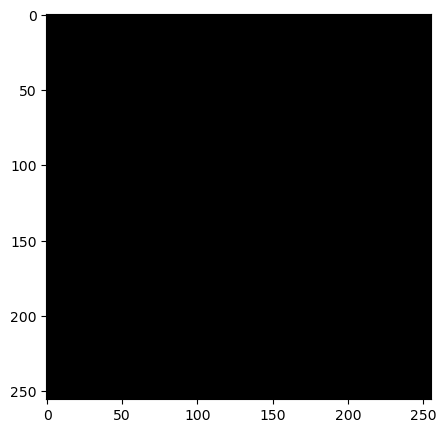

In [59]:
import matplotlib.pyplot as plt

# Assuming you have defined `sample_test_img` and `img_idx` somewhere in your code
# For example: sample_test_img = ...

%matplotlib inline
fig_test_img = output_path + "fig_test_img.pdf"
fig = plt.figure(figsize=(6, 5))
img_idx=0
imgplot = plt.imshow(sample_test_img[img_idx].astype('uint8'))
plt.show()
fig.savefig(fig_test_img, format='pdf')


NameError: name 'sum_attnmap' is not defined

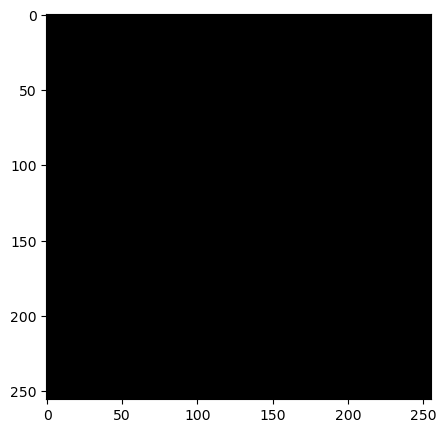

In [58]:
fig_heatmap=output_path+"fig_heatmap.pdf"
fig=plt.figure(figsize=(6,5))
plt.imshow(sample_test_img[img_idx].astype('uint8'),alpha=1.0)
plt.imshow(cv2.resize(sum_attnmap,(IMG_SIZE,IMG_SIZE),interpolation=cv2.INTER_CUBIC),cmap='jet',alpha=0.5)
plt.show()
fig.savefig(fig_heatmap, format='pdf')

In [60]:
tf.keras.utils.plot_model(model, to_file=output_path+r'model.pdf', 
    show_shapes=True,    
    show_dtype=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=1200,
    layer_range=None,
    show_layer_activations=True,
)

In [61]:
tf.keras.utils.plot_model(model, to_file=output_path+r'model.png', 
    show_shapes=True,    
    show_dtype=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=1200,
    layer_range=None,
    show_layer_activations=True,
)

In [62]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 depthwise_conv2d (Depthwise  (None, 256, 256, 3)      30        
 Conv2D)                                                         
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 3)      12        
 ormalization)                                                   
                                                                 
 chn (Functional)            (None, None, None, 3)     3         
                                                                 
 spt (Functional)            (None, None, None, 3)     102       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 3)      0     

Model-2(Functional)
